# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada" data-toc-modified-id="Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (2): Usando uma rede pré-treinada</a></div><div class="lev2 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Procedimento-de-treino" data-toc-modified-id="Procedimento-de-treino-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Procedimento de treino</a></div><div class="lev2 toc-item"><a href="#Obtenção-de-atributos-através-da-VGG" data-toc-modified-id="Obtenção-de-atributos-através-da-VGG-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Obtenção de atributos através da VGG</a></div><div class="lev2 toc-item"><a href="#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Construção da rede neural</a></div><div class="lev2 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev2 toc-item"><a href="#Avaliação" data-toc-modified-id="Avaliação-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliação</a></div><div class="lev2 toc-item"><a href="#Atividade" data-toc-modified-id="Atividade-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Atividade</a></div><div class="lev2 toc-item"><a href="#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Aprendizados com este notebook</a></div>

# Cats and Dogs (2): Usando uma rede pré-treinada

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é parte 2 de três sobre *transfer learning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)
nr.seed(20170603)

Using TensorFlow backend.


Keras  2.0.4


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


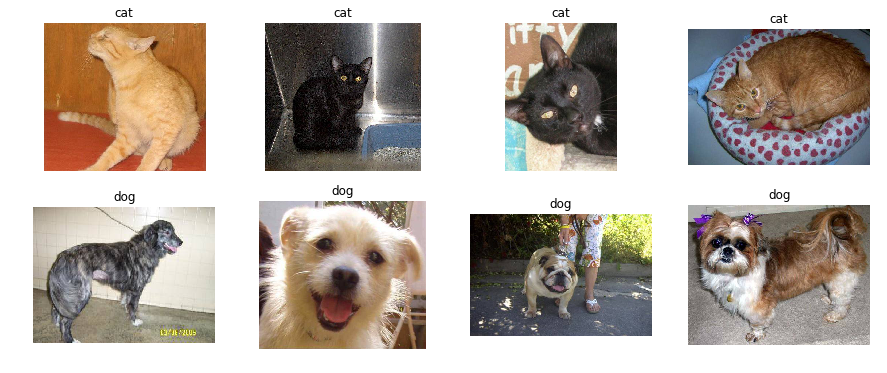

In [3]:
train_data_dir = '../../datasets/CatsDogs/train'
valid_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_valid_samples = 800

fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, 4)):
    fig.add_subplot(2,4, i+1)
    img = plot.imread('{}/cats/cat.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.title('cat')
    plot.axis('off')
    
    fig.add_subplot(2,4, i+5)
    img = plot.imread('{}/dogs/dog.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.title('dog')
    plot.axis('off')


In [4]:
batch_size = 40
img_width, img_height = 150, 150

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_data_dir,                       # as amostras de treinamento
        target_size=(img_width, img_height),
        batch_size=batch_size,                # batch size do SGD
        shuffle=False,
)

valid_generator = datagen.flow_from_directory(
        valid_data_dir,                       # as amostras de validação
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
)


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Procedimento de treino

In [5]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, Xtra, ytra, Xval=None, yval=None, 
                  opt='rmsprop', batch_size=60, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        h = model.fit(Xtra, ytra, batch_size=60, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Obtenção de atributos através da VGG

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_original.png)]()

In [6]:
from keras.applications.vgg16 import VGG16
VGG16(include_top=False, weights='imagenet', input_shape=(150,150, 3)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
def get_and_save_vgg_features(trn_feat_fn, val_feat_fn):

    # carrega apenas a parte convolucional (include_top=False) da VGG16
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
    train_features = vgg.predict_generator(train_generator, nb_train_samples/batch_size)
    np.save(open(trn_feat_fn, 'wb'), train_features)
    
    valid_features = vgg.predict_generator(valid_generator, nb_valid_samples/batch_size)
    np.save(open(val_feat_fn, 'wb'), valid_features)
    
    return train_features, valid_features

trn_feat_fn = '../../models/vgg16_150x150_features_train.npy'
val_feat_fn = '../../models/vgg16_150x150_features_valid.npy'

if not os.path.isfile(trn_feat_fn):
    train_features, valid_features = get_and_save_vgg_features(trn_feat_fn, val_feat_fn)
else:
    train_features = np.load(open(trn_feat_fn, 'rb'))
    valid_features = np.load(open(val_feat_fn, 'rb'))
    
train_labels = np.array([0] * 1000 + [1] * 1000)
valid_labels = np.array([0] * 400 + [1] * 400)

## Construção da rede neural
A rede neural utilizada é especificada a seguir.

In [8]:
model_name = '../../models/cats_dogs_vgg'

def build_net(img_width, img_height):
    model = Sequential()
    model.add(Flatten(input_shape=train_features.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_net(img_width, img_height)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


## Treinamento

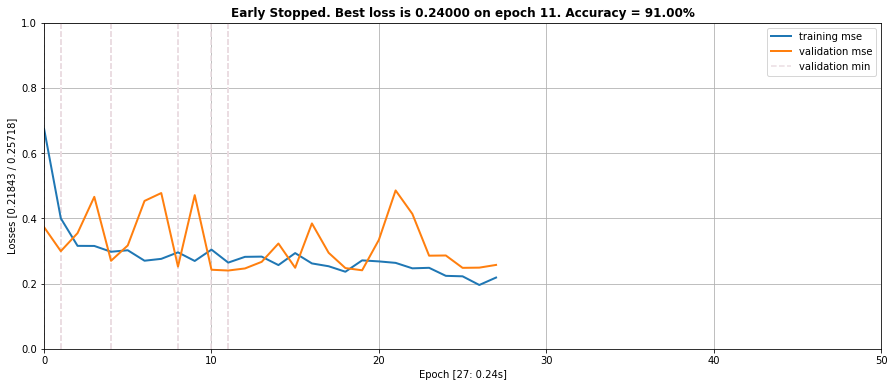

In [9]:
fit_params = {
    'opt':             SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           True,
}

train_network(model, model_name, train_features, train_labels, valid_features, valid_labels, **fit_params);

## Avaliação

In [10]:
test_network(model_name, valid_features, valid_labels)

Model from epoch 11
[INFO] evaluating in the test data set ...
 40/800 [>.............................] - ETA: 0s
[INFO] accuracy on the test data set: 91.00% [0.24000]


## Atividade

1. Criar a rede VGG16 com pesos vencedores da Imagenet concatena com a rede Densa treinada neste notebook. Fazer a avalição desta rede com os dados de validação.


## Aprendizados com este notebook

1. O uso de uma rede pré-treinada com pesos utilizados em competições, serve para a extração eficiente de atributos das imagens de um modo geral. 
2. Os features gerados pela rede VGG16 podem ser utilizados para classificação utilizando qualquer classificador. Neste caso utilizamos um classificador por rede neural densa. Desta forma, poderemos posteriormente treinar a rede toda. Isso será visto no próximo notebook.
